# Create plots to highlight linear relationships

In [1]:
# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

import regionmask
import cartopy.crs as ccrs

from emcli2.dataset.interim_to_processed import calculate_global_weighted_average

In [2]:
#@title code: load ClimateBench data
from emcli2.dataset.climatebench import load_climatebench_data

repo_root = '../'
data_root = '../../../data/climate-emulator-presubmission-tst/data/'

# Uncomment these on MIT svante computer
# repo_root = '../../climate-emulator-tutorial/' 
# data_root = repo_root + 'data/'

data_path_climatebench = data_root + 'raw/climatebench/' # climatebench data + '/'

scenarios_train = ['historical','ssp126','ssp370','ssp585'] # 1pctCO2, picontrol, hist-aer, hist-GHG, abrupt-4xCO2

X_train, _ = load_climatebench_data(
  simus=scenarios_train, len_historical=0, 
  data_path=data_path_climatebench)

scenarios_test = ['ssp245']
len_historical = 165

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path_climatebench,
  avg_over_ensemble=True)

X_data = X_train[0:2] + [X_test[0].sel(time=slice(2015,None))] + X_train[2:]
scenarios =  scenarios_train[0:2] + scenarios_test + scenarios_train[2:4]

FrozenMappingWarningOnValuesAccess({'time': 165, 'longitude': 144, 'latitude': 96}) historical
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp126
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 86, 'longitude': 144, 'latitude': 96}) ssp585
FrozenMappingWarningOnValuesAccess({'time': 251, 'latitude': 96, 'longitude': 144}) ssp245


In [3]:
# Retrieve MPI-ESM1.2-LR data

from emcli2.dataset.mpi_esm1_2_lr import get_meta
from emcli2.dataset.mpi_esm1_2_lr import get_filepaths_mpi_esm1_2_lr
from emcli2.dataset.mpi_esm1_2_lr import create_train_splits
from emcli2.dataset.mpi_esm1_2_lr import load_mpi_data_as_xr

data_vars = ['tas','pr']

repo_root = '../'
data_root = '../../../data/climate-emulator-presubmission-tst/data/'
# Uncomment these on MIT svante computer
# data_root = '/d3/lutjens/bc3/data/'
data_path = data_root + 'raw/CMIP6/MPI-ESM1-2-LR/' # raw data downloaded from CMIPX
data_path_interim = data_root + 'interim/CMIP6/MPI-ESM1-2-LR/' # interim data, such as, statistical summaries
meta = get_meta(data_path=data_path, data_path_interim=data_path_interim)
# Load MPI-ESM1-2-LR target climate variable data

scenarios_train = ['historical','ssp126','ssp370','ssp585'] # 1pctCO2, picontrol, hist-aer, hist-GHG, abrupt-4xCO2
scenarios_aux = [] # auxiliary scenarios that are not used for train or test, e.g., 1pctCO2, picontrol, hist-aer, hist-GHG, abrupt-4xCO2
scenarios_test = ['ssp245']

# We currently only have targets for ssp119, but not inputs.
add_ssp119 = False
if add_ssp119:
    scenarios_train = ['historical','ssp119','ssp126','ssp370','ssp585'] # 1pctCO2, picontrol, hist-aer, hist-GHG, abrupt-4xCO2

# Load precomputed ensemble summaries for runtime increase.
scenarios = scenarios_train + scenarios_test + scenarios_aux
df = get_filepaths_mpi_esm1_2_lr(data_vars=data_vars,
        scenarios=scenarios,
        data_path=data_path_interim,
        filename_wildcard='ensemble_summaries_yr.nc',
        frequencies=[meta[data_var]['frequency'] for data_var in data_vars],
        verbose=False)


### Plot global tas over cumulative CO2 emissions 

In [4]:
data_var = 'tas'
datasets, climatology = load_mpi_data_as_xr(df=df[df.data_var == data_var], meta=meta,
                    climatology=None,
                    m_member_subset=None,
                    open_data_parallel=False)
climatology.load();

#from emcli2.utils.plotting import plot_climatology_map
#plot_climatology_map(climatology,
#    data_var=data_var, 
#    unit=meta[data_var]['unit'],
#    filepath_to_save=f'{repo_root}/docs/figures/mpi-esm1-2-lr/{data_var}/{data_var}_climatology.png',
#    dpi=100);

Y_train_mpi, Y_test_mpi, Y_aux_mpi = create_train_splits(datasets, data_var=data_var,
                                            scenarios_train=scenarios_train,
                                            scenarios_test=scenarios_test,
                                            scenarios_aux=scenarios_aux,
                                            verbose=True)

if not add_ssp119:
    Y_mpi_tas = Y_train_mpi[0:2] + [Y_test_mpi[0].sel(time=slice('2015',None))] + Y_train_mpi[2:]
    scenarios =  scenarios_train[0:2] + scenarios_test + scenarios_train[2:]
    colors = ['tab:blue', 'tab:green', 'black', 'tab:orange', 'tab:red', 'tab:purple']
else:
    Y_mpi_tas = Y_train_mpi[0:3] + [Y_test_mpi[0].sel(time=slice('2015',None))] + Y_train_mpi[3:]
    scenarios =  scenarios_train[0:3] + scenarios_test + scenarios_train[3:]
    colors = ['tab:blue', 'tab:brown', 'tab:green', 'black', 'tab:orange', 'tab:red', 'tab:purple']

If next line throws segmentation fault, try changing config.open_data_parallel to False.


/home/bjoern/miniconda3/envs/emcli-presubmission-tst/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


[########################################] | 100% Completed | 15.58 s


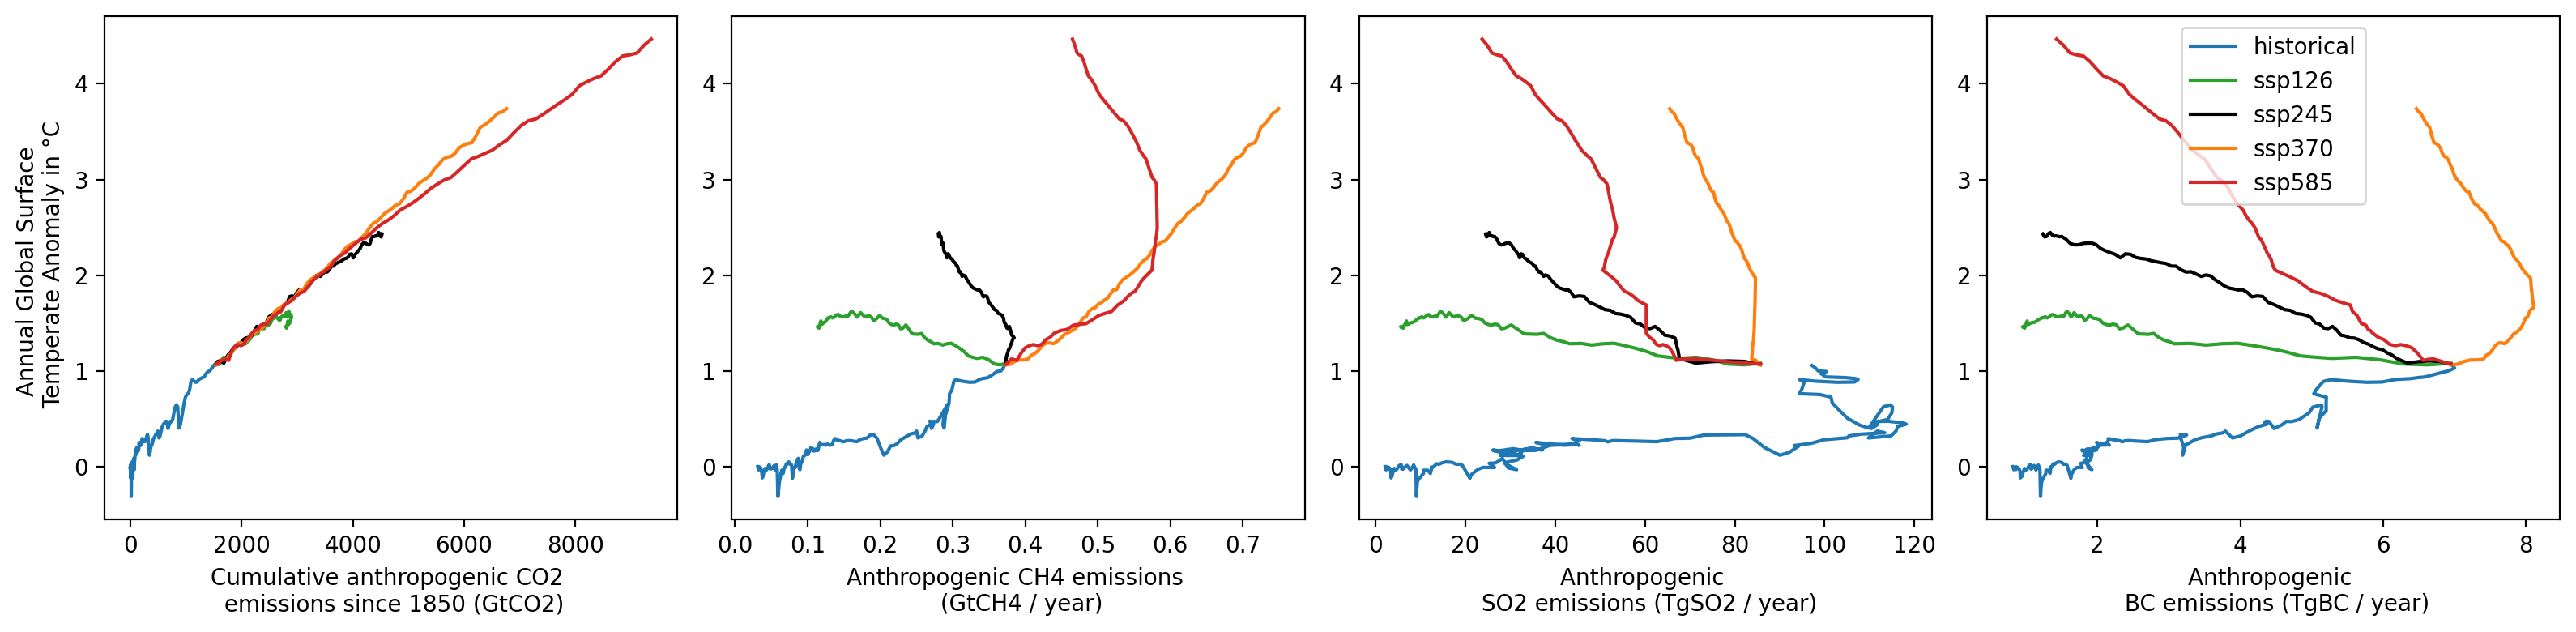

In [5]:
# (optional) Plot globally-summed emissions over globally-averaged surface temperature

from emcli2.dataset.mpi_esm1_2_lr import get_meta

if not add_ssp119:
    fig, axs = plt.subplots(1,4, figsize =(16,4),dpi=200)

    meta = get_meta(data_path=data_path, data_path_interim=None)

    SECONDS_IN_YEAR = 60*60*24*365 #s
    convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt
    AREA_of_EARTH = 510.1 * 1e6 #million km²

    def global_sum(ds):
        weights = np.cos(np.deg2rad(ds.latitude))
        return ds.weighted(weights).sum(['latitude', 'longitude'])

    # Plot global surface temperature over cum. co2 emissions
    for idx, scenario in enumerate(scenarios):
        axs[0].plot(X_data[idx]['CO2'], calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), label=scenario,color=colors[idx])
    axs[0].set_xlabel("Cumulative anthropogenic CO2 \n emissions since 1850 (GtCO2)")
    for idx, scenario in enumerate(scenarios):
        axs[1].plot(X_data[idx]['CH4'], calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), label=scenario,color=colors[idx])
    axs[1].set_xlabel("Anthropogenic CH4 emissions \n (GtCH4 / year)")
    for idx, scenario in enumerate(scenarios):
        axs[2].plot(convert(global_sum(X_data[idx]['SO2']*AREA_of_EARTH*1000*100)), calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), label=scenario,color=colors[idx])
    axs[2].set_xlabel("Anthropogenic \n SO2 emissions (TgSO2 / year)")
    for idx, scenario in enumerate(scenarios):
        axs[3].plot(convert(global_sum(X_data[idx]['BC']*AREA_of_EARTH*1000*100)), calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), label=scenario,color=colors[idx])
    axs[3].set_xlabel("Anthropogenic \n BC emissions (TgBC / year)")

    #for idx, scenario in enumerate([scenarios_train[0]]):
    #    axs.plot(X_train[idx]['CH4'].sel(time=slice(None,2015)), calculate_global_weighted_average(Y_train[idx][data_var].sel(time=slice(None,'2015'))), label='historical',color='tab:blue')
    #for idx, scenario in enumerate(scenarios_test):
    #    axs.plot(X_test[idx]['CH4'].sel(time=slice('2015',None)), calculate_global_weighted_average(Y_test_mpi[idx][data_var].sel(time=slice('2015',None))), color='black', label=scenario)
    axs[0].set_ylabel(meta[data_var]['ylabel'])
    # axs.set_title(f"CH4 vs. {data_var}")
    plt.legend()
    plt.tight_layout()


## Plot local tas over global tas for some regions:

All regions:
0 GIC Greenland/Iceland
1 NWN N.W.North-America
2 NEN N.E.North-America
3 WNA W.North-America
4 CNA C.North-America
5 ENA E.North-America
6 NCA N.Central-America
7 SCA S.Central-America
8 CAR Caribbean
9 NWS N.W.South-America
10 NSA N.South-America
11 NES N.E.South-America
12 SAM South-American-Monsoon
13 SWS S.W.South-America
14 SES S.E.South-America
15 SSA S.South-America
16 NEU N.Europe
17 WCE West&Central-Europe
18 EEU E.Europe
19 MED Mediterranean
20 SAH Sahara
21 WAF Western-Africa
22 CAF Central-Africa
23 NEAF N.Eastern-Africa
24 SEAF S.Eastern-Africa
25 WSAF W.Southern-Africa
26 ESAF E.Southern-Africa
27 MDG Madagascar
28 RAR Russian-Arctic
29 WSB W.Siberia
30 ESB E.Siberia
31 RFE Russian-Far-East
32 WCA W.C.Asia
33 ECA E.C.Asia
34 TIB Tibetan-Plateau
35 EAS E.Asia
36 ARP Arabian-Peninsula
37 SAS S.Asia
38 SEA S.E.Asia
39 NAU N.Australia
40 CAU C.Australia
41 EAU E.Australia
42 SAU S.Australia
43 NZ New-Zealand
44 EAN E.Antarctica
45 WAN W.Antarctica
46 ARO Arctic-

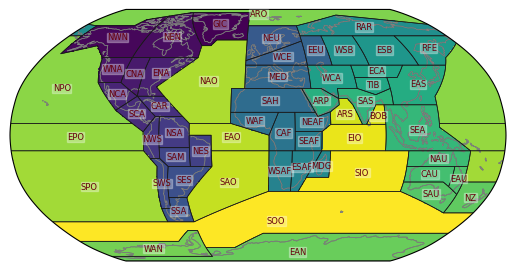

In [6]:
# Plot IPCC WGI AR6 reference regions
# See documentation at https://github.com/SantanderMetGroup/ATLAS/blob/main/notebooks/reference-regions_Python.ipynb
# See region names at: https://essd.copernicus.org/articles/12/2959/2020/essd-12-2959-2020-f01-web.png

# Load reference regions
ar6_all = regionmask.defined_regions.ar6.all

# Init plot
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))
text_kws = dict(color="#67000d", fontsize=6, bbox=dict(pad=0.2, color="w", alpha=0.3)) # style guide for text

ax = ar6_all.plot(
    ax=ax,
    add_ocean=True,
    label="abbrev",
    line_kws=dict(linewidth=0.5),
    text_kws=text_kws,
)
ax.coastlines(color="0.5", lw=0.5)

lon = np.arange(-179.5, 180)
lat = np.arange(-89.5, 90)
mask = regionmask.defined_regions.ar6.all.mask(lon, lat)
mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

print('All regions:')
[print(i, region.abbrev, region.name) for i, region in enumerate(regionmask.defined_regions.ar6.all)]
plt.show()

plt.close()

plotting scenario  historical
plotting scenario  ssp126
plotting scenario  ssp245
plotting scenario  ssp370
plotting scenario  ssp585


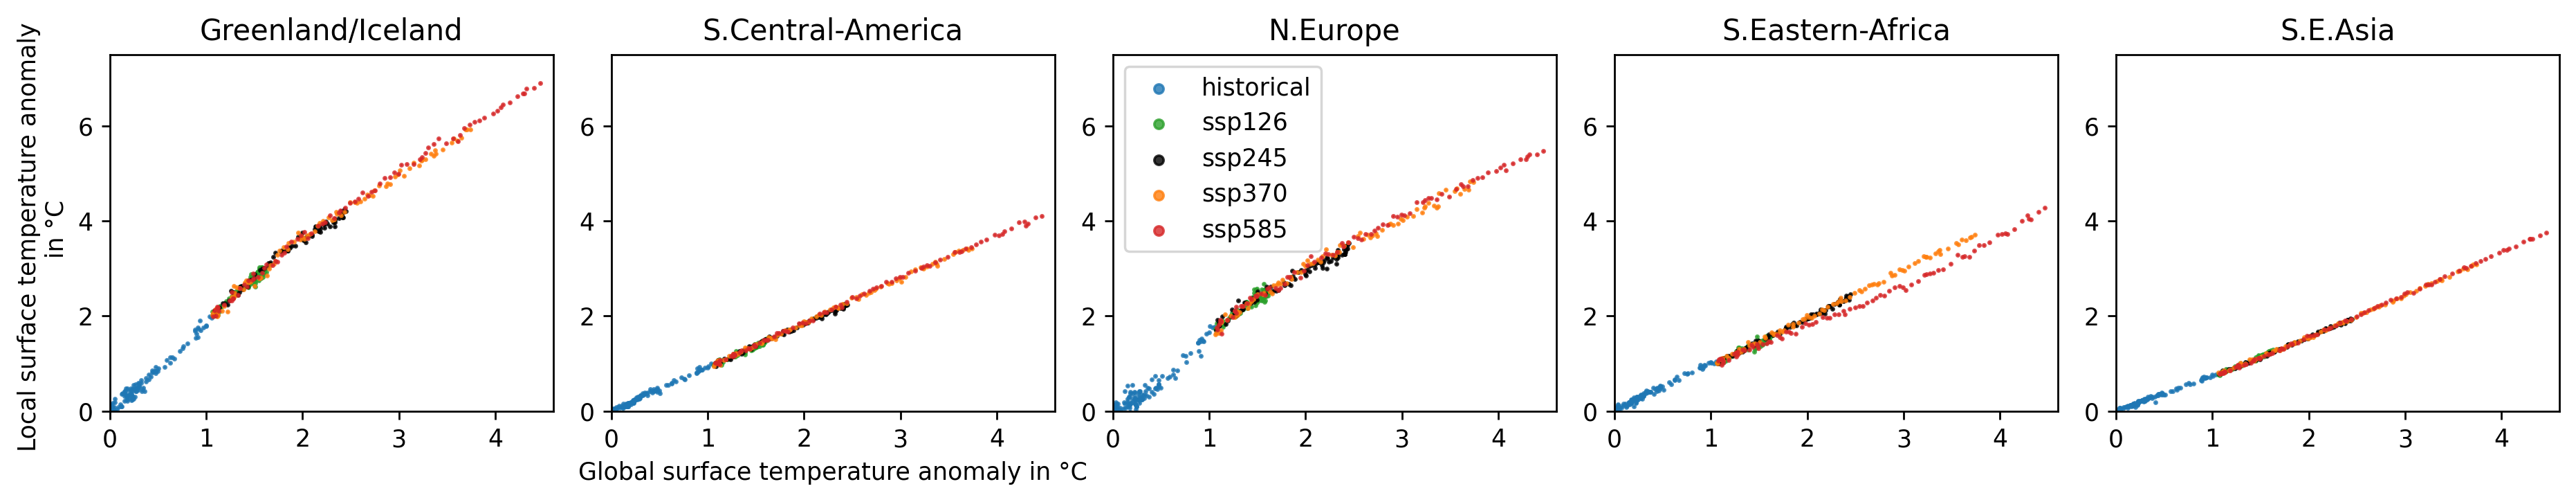

In [7]:
filepath_to_save = f'../docs/figures/mpi-esm1-2-lr/{data_var}/linearity/local_var_over_global_tas'

region_names=['Greenland/Iceland']
# Regions in Womack et al. paper
# region_names =  ['N.W.North-America', 'W.Southern-Africa', 'N.W.South-America', 'S.Central-America', 'S.E.Asia']# , 'W.Antarctica']
# Regions from Lutjens et al., JAMES24 paper:
region_names =  ['Greenland/Iceland', 'N.Europe', 'S.E.Asia', 'S.Central-America', 'S.Eastern-Africa']

plot_21yr_avg = False

# Get region information from IPCC AR6 regions
ar6_all = regionmask.defined_regions.ar6.all
region = ar6_all[region_names]
region_idxs = list(region.regions.keys())

n_cols = len(region_idxs)
fig, axs = plt.subplots(1, n_cols, figsize=(3*n_cols,3), dpi=250) 

xlim = (0, 4.6)
ylim = (0,7.5)

for idx, scenario in enumerate(scenarios):
    print('plotting scenario ',scenario)
            
    tas_local = Y_mpi_tas[idx][data_var]
    weights = np.cos(np.deg2rad(Y_mpi_tas[idx][data_var].latitude))
    tas_global = Y_mpi_tas[idx][data_var].weighted(weights).mean(dim=("latitude", "longitude"))
    years = tas_local.time.dt.year

    # Create regional weighted average
    mask_3D = ar6_all.mask_3D(tas_local) # mask with region information
    tas_regional = tas_local.weighted(mask_3D * weights).mean(dim=("latitude", "longitude"))

    years = tas_local.time.dt.year

    for row_id, region_idx in enumerate(region_idxs):
        if not plot_21yr_avg:
            axs[row_id].scatter(tas_global, tas_regional.sel(region=region_idx), c=colors[idx], marker='o', s=1, alpha=0.8)
        else:
            var_regional_21yr = tas_regional.rolling(time=21, center=True).mean().dropna('time')
            tas_global_21yr = tas_global.rolling(time=21, center=True).mean().dropna('time')
            axs[row_id].scatter(tas_global_21yr, var_regional_21yr.sel(region=region_idx), c=colors[idx], marker='o', s=1, linewidth=0.05, alpha=0.8)

        # add legend labels
        axs[row_id].scatter(xlim[1]+1, ylim[1]+1, c=colors[idx], marker='o', s=15, alpha=0.8, label=scenario)

        if idx == 0:
            axs[row_id].set_xlim(xlim)
            axs[row_id].set_ylim(ylim)
            axs[row_id].set_title(f'{ar6_all[region_idx].name}')
        if idx == len(scenarios)-1 and row_id == 2:
            axs[row_id].legend()

axs[0].set_ylabel("Local surface temperature anomaly \n in °C")
axs[1].set_xlabel("Global surface temperature anomaly in °C")

plt.tight_layout()
if filepath_to_save is not None:
    if plot_21yr_avg:
        filepath_to_save = filepath_to_save + '_21yr'
    if add_ssp119:
        filepath_to_save = filepath_to_save + '_w119'
    filepath_to_save = filepath_to_save + '.png'
    Path(filepath_to_save).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(filepath_to_save)

plt.show()
plt.close()

## Plot local pr over global tas for some regions

In [8]:
data_var = 'pr'
datasets, climatology = load_mpi_data_as_xr(df=df[df.data_var == data_var], meta=meta,
                    climatology=None,
                    m_member_subset=None,
                    open_data_parallel=False)
climatology.load();

#from emcli2.utils.plotting import plot_climatology_map
#plot_climatology_map(climatology,
#    data_var=data_var, 
#    unit=meta[data_var]['unit'],
#    filepath_to_save=f'{repo_root}/docs/figures/mpi-esm1-2-lr/{data_var}/{data_var}_climatology.png',
#    dpi=100);

Y_train_mpi, Y_test_mpi, Y_aux_mpi = create_train_splits(datasets, data_var=data_var,
                                            scenarios_train=scenarios_train,
                                            scenarios_test=scenarios_test,
                                            scenarios_aux=scenarios_aux,
                                            verbose=True)
if not add_ssp119:
    Y_mpi_var = Y_train_mpi[0:2] + [Y_test_mpi[0].sel(time=slice('2015',None))] + Y_train_mpi[2:]
    scenarios =  scenarios_train[0:2] + scenarios_test + scenarios_train[2:]
    colors = ['tab:blue', 'tab:green', 'black', 'tab:orange', 'tab:red', 'tab:purple']
else:
    Y_mpi_var = Y_train_mpi[0:3] + [Y_test_mpi[0].sel(time=slice('2015',None))] + Y_train_mpi[3:]
    scenarios =  scenarios_train[0:3] + scenarios_test + scenarios_train[3:]
    colors = ['tab:blue', 'tab:brown', 'tab:green', 'black', 'tab:orange', 'tab:red', 'tab:purple']

If next line throws segmentation fault, try changing config.open_data_parallel to False.


/home/bjoern/miniconda3/envs/emcli-presubmission-tst/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


[########################################] | 100% Completed | 16.68 s


plotting tas scenario  historical
plotting tas scenario  ssp126
plotting tas scenario  ssp245
plotting tas scenario  ssp370
plotting tas scenario  ssp585
plotting pr scenario  historical
plotting pr scenario  ssp126
plotting pr scenario  ssp245
plotting pr scenario  ssp370
plotting pr scenario  ssp585


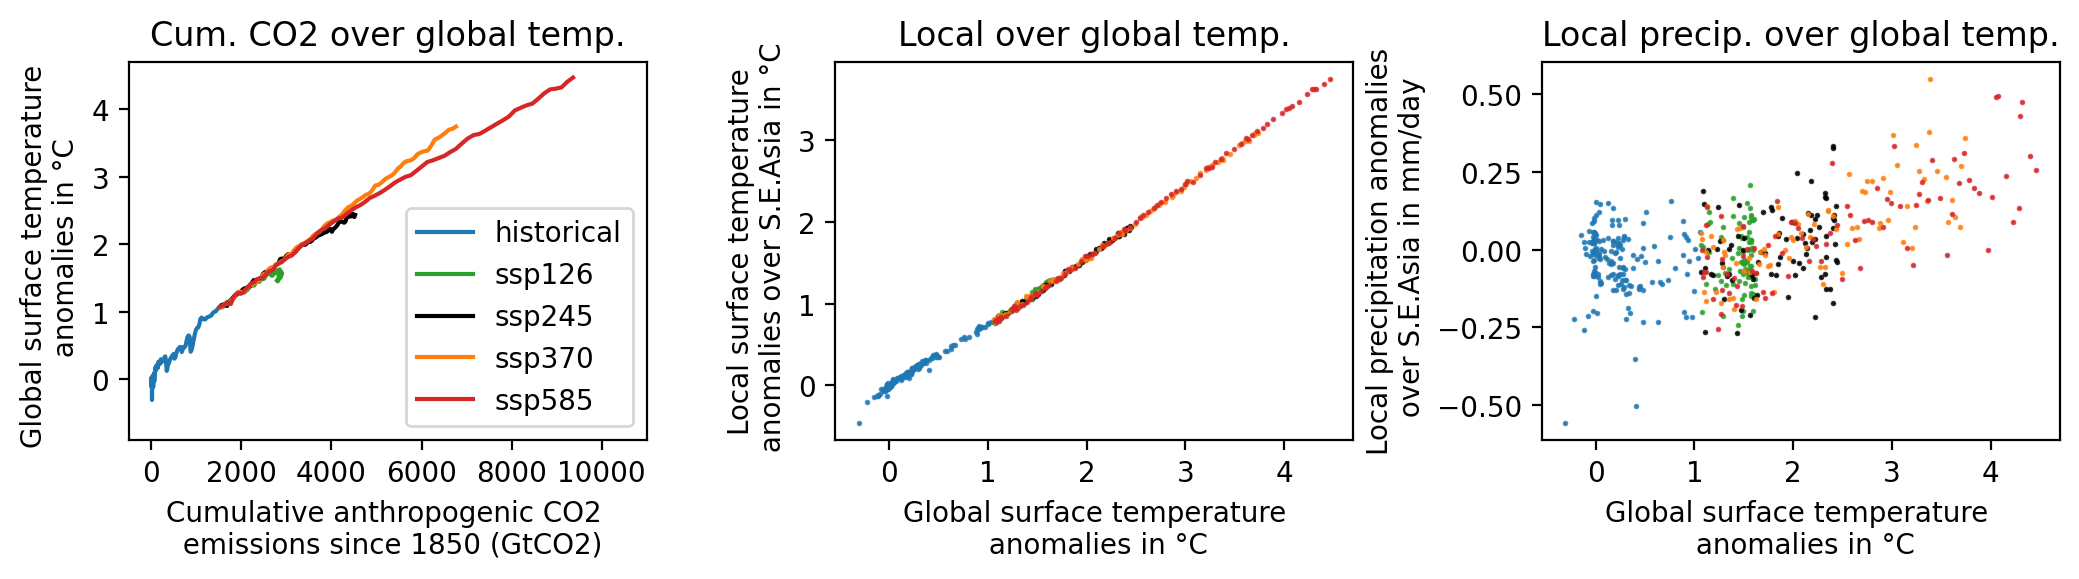

In [15]:
region_name = 'S.E.Asia'
data_var = 'pr'
filepath_to_save = f'../docs/figures/mpi-esm1-2-lr/{data_var}/linearity/{region_name.replace(".","_")}'
plot_21yr_avg = False

if not add_ssp119:
    fig, axs = plt.subplots(1, 3, figsize=(3*3.5,3), dpi=200) 

    for idx, scenario in enumerate(scenarios):
        axs[0].plot(X_data[idx]['CO2'], calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), label=scenario,color=colors[idx])
    axs[0].set_xlabel("Cumulative anthropogenic CO2 \n emissions since 1850 (GtCO2)")
    axs[0].set_ylabel("Global surface temperature \n anomalies in °C")
    axs[0].set_ylim(-0.9, 4.7)
    axs[0].set_xlim(-500, 11000)
    axs[0].legend(loc='lower right')
    axs[0].set_title('Cum. CO2 over global temp.')
    # Get region information from IPCC AR6 regions
    ar6_all = regionmask.defined_regions.ar6.all
    region = ar6_all[region_name]
    region_idx = region.number

    if True:
        # Plot regional surface temperature over global surface temperature
        for idx, scenario in enumerate(scenarios):
            print('plotting tas scenario ',scenario)
            # Create regional weighted average
            tas_local = Y_mpi_tas[idx]['tas']
            mask_3D = ar6_all.mask_3D(tas_local) # mask with region information
            tas_regional = tas_local.weighted(mask_3D * weights).mean(dim=("latitude", "longitude"))
            axs[1].scatter(calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), tas_regional.sel(region=region_idx), c=colors[idx], marker='o', s=1, alpha=0.8, label=scenario)
        axs[1].set_xlabel("Global surface temperature\n anomalies in °C")
        axs[1].set_ylabel(f"Local surface temperature\n anomalies over {region_name} in °C")
        axs[1].set_title('Local over global temp.')

        # Plot regional precipitation over global surface temperature
        for idx, scenario in enumerate(scenarios):
            print('plotting pr scenario ',scenario)
            # Create regional weighted average
            var_local = Y_mpi_var[idx][data_var]
            mask_3D = ar6_all.mask_3D(var_local) # mask with region information
            var_regional = var_local.weighted(mask_3D * weights).mean(dim=("latitude", "longitude"))
            if not plot_21yr_avg:
                axs[2].scatter(calculate_global_weighted_average(Y_mpi_tas[idx]['tas']), var_regional.sel(region=region_idx), c=colors[idx], marker='o', s=1, alpha=0.8)
            else:
                var_regional_21yr = var_regional.rolling(time=21, center=True).mean().dropna('time')
                tas_global_21yr = Y_mpi_tas[idx]['tas'].rolling(time=21, center=True).mean().dropna('time')
                axs[2].scatter(calculate_global_weighted_average(tas_global_21yr), var_regional_21yr.sel(region=region_idx), c=colors[idx], marker='o', s=1, alpha=0.8)
                
        axs[2].set_xlabel("Global surface temperature \n anomalies in °C")
        axs[2].set_ylabel(f"Local precipitation anomalies\n over {region_name} in mm/day")
        axs[2].set_title('Local precip. over global temp.')

    plt.tight_layout()
    if filepath_to_save is not None:
        if plot_21yr_avg:
            filepath_to_save = filepath_to_save + '_21yr'
        if add_ssp119:
            filepath_to_save = filepath_to_save + '_w119'
        filepath_to_save = filepath_to_save + '.png'
        Path(filepath_to_save).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(filepath_to_save)

    plt.show()
    plt.close()


plotting scenario  historical
plotting scenario  ssp126
plotting scenario  ssp245
plotting scenario  ssp370
plotting scenario  ssp585


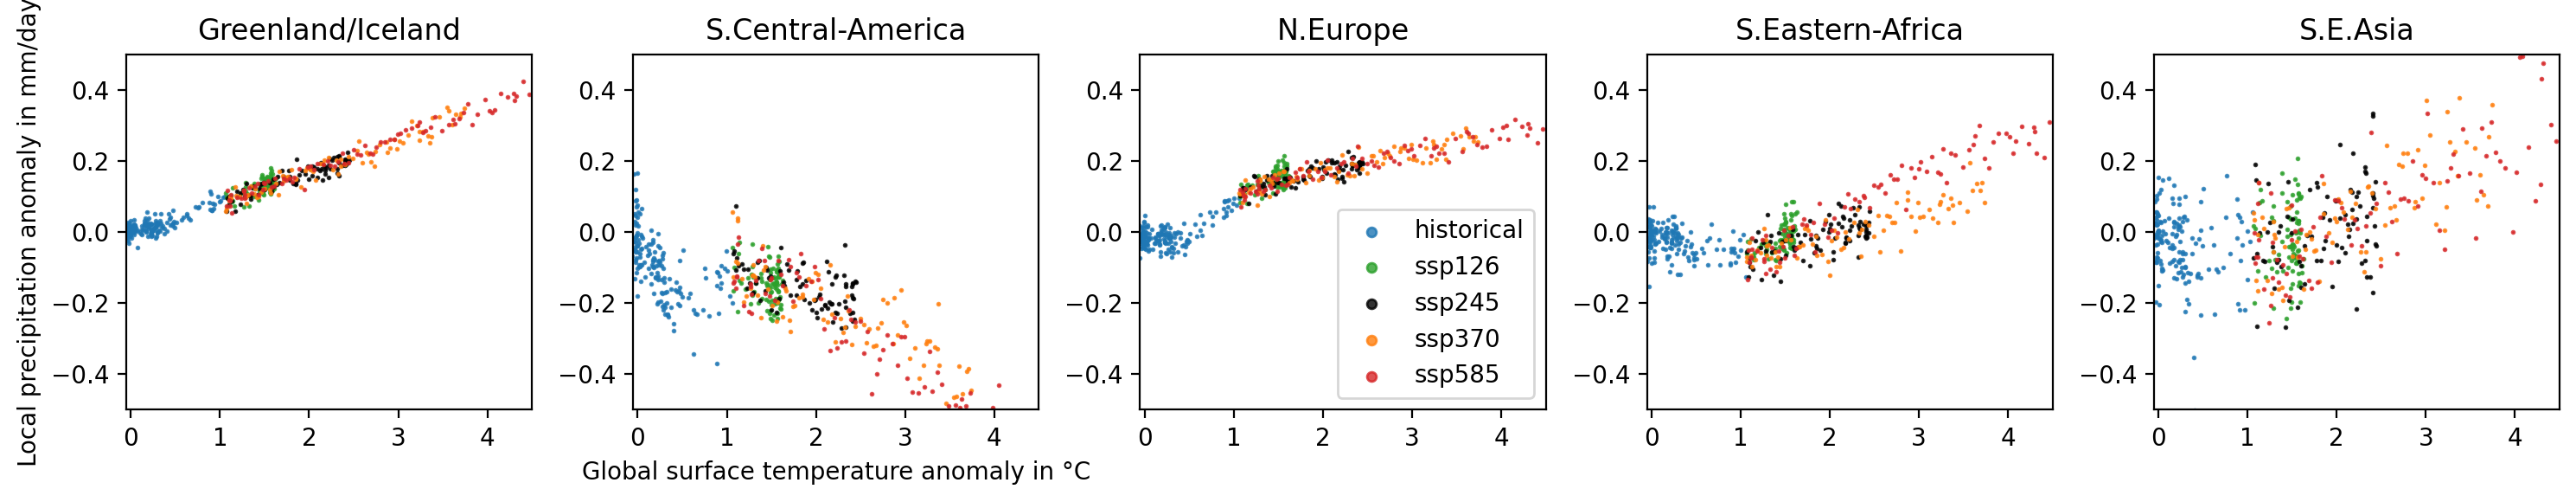

In [10]:
filepath_to_save = f'../docs/figures/mpi-esm1-2-lr/{data_var}/linearity/local_var_over_global_tas'

region_names=['Greenland/Iceland']
region_names = ['Greenland/Iceland', 'N.Europe', 'N.Central-America', 'S.Eastern-Africa', 'W.Antarctica']
# region_names = ['Greenland/Iceland', 'Russian-Arctic', 'E.North-America', 'S.Central-America','South-American-Monsoon','S.South-America','N.Europe','Sahara','E.Asia', 'S.E.Asia', 'W.Antarctica','Equatorial.Pacific-Ocean','Southern-Ocean']
region_names =  ['Greenland/Iceland', 'N.Europe', 'S.E.Asia', 'S.Central-America', 'S.Eastern-Africa']# , 'W.Antarctica']

plot_21yr_avg = False

# Get region information from IPCC AR6 regions
ar6_all = regionmask.defined_regions.ar6.all
region = ar6_all[region_names]
region_idxs = list(region.regions.keys())

n_cols = len(region_idxs)
fig, axs = plt.subplots(1, n_cols, figsize=(3*n_cols,3), dpi=200) 

xlim = (-0.05,4.5)
ylim = (-0.5, 0.5)

for idx, scenario in enumerate(scenarios):
    print('plotting scenario ',scenario)
            
    tas_local = Y_mpi_tas[idx]['tas']
    weights = np.cos(np.deg2rad(Y_mpi_tas[idx]['tas'].latitude))
    tas_global = Y_mpi_tas[idx]['tas'].weighted(weights).mean(dim=("latitude", "longitude"))
    years = tas_local.time.dt.year

    var_local = Y_mpi_var[idx][data_var]

    # Create regional weighted average
    mask_3D = ar6_all.mask_3D(var_local) # mask with region information
    var_regional = var_local.weighted(mask_3D * weights).mean(dim=("latitude", "longitude"))

    years = var_local.time.dt.year

    for row_id, region_idx in enumerate(region_idxs):
        # axs[row_id].plot(tas_global, var_regional.sel(region=region_idx), c=colors[idx], label=scenario)#, color=labels['color'])
        if not plot_21yr_avg:
            axs[row_id].scatter(tas_global, var_regional.sel(region=region_idx), c=colors[idx], marker='o', s=1, alpha=0.8)
        else:
            var_regional_21yr = var_regional.rolling(time=21, center=True).mean().dropna('time')
            tas_global_21yr = tas_global.rolling(time=21, center=True).mean().dropna('time')
            axs[row_id].scatter(tas_global_21yr, var_regional_21yr.sel(region=region_idx), c=colors[idx], marker='o', linewidth=0.05, s=1, alpha=0.8)

        # add legend labels
        axs[row_id].scatter(xlim[1]+1, ylim[1]+1, c=colors[idx], marker='o', s=15, alpha=0.8, label=scenario)

        if idx == 0:
            axs[row_id].set_xlim(xlim)
            axs[row_id].set_ylim(ylim)
            axs[row_id].set_title(f'{ar6_all[region_idx].name}')
        if idx == len(scenarios)-1 and row_id == 2:
            axs[row_id].legend()

axs[0].set_ylabel("Local precipitation anomaly in mm/day")
axs[1].set_xlabel("Global surface temperature anomaly in °C")

plt.tight_layout()
if filepath_to_save is not None:
    if plot_21yr_avg:
        filepath_to_save = filepath_to_save + '_21yr'
    if add_ssp119:
        filepath_to_save = filepath_to_save + '_w119'
    filepath_to_save = filepath_to_save + '.png'
    Path(filepath_to_save).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(filepath_to_save)

plt.show()
plt.close()